In [0]:
# importing important libraries

import torch
import torch.nn as nn
from torch import nn,optim
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torchvision import models

from torchsummary import summary
import torch.optim as optim
import torch.utils.data


import numpy as np
import pandas as pd

import sys
import time
import math
import datetime as dt

import matplotlib.pyplot as plt
%matplotlib inline

import tqdm
import argparse

import glob

import tarfile
import warnings 
warnings.filterwarnings("ignore")

In [63]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/ShuffleNet')

In [0]:
from PIL import Image
from keras.datasets import cifar10

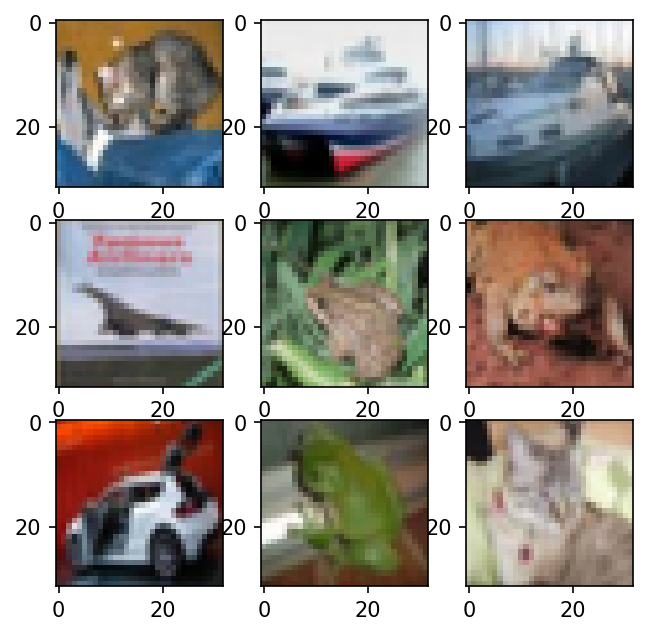

In [66]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(5, 5), dpi=150, facecolor='w', edgecolor='k')

def show_imgs(X):
    plt.figure(1)
    k = 0
    for i in range(0,3):
        for j in range(0,3):
            plt.subplot2grid((3,3),(i,j))
            plt.imshow(Image.fromarray(X[k]))
            k = k+1
    # show the plot
    plt.show()
 
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
show_imgs(x_test[:9])



In [0]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

best_acc = 0     # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

In [68]:
print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.Pad(4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32),
 #   transforms.ColorJitter(brightness=1, contrast=0, saturation=0, hue=0),
 #   transforms.RandomRotation(degrees=[-15,15], resample=False, expand=False, center=None, fill=0),
 #   transforms.RandomGrayscale(p=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.Pad(4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32),
 #   transforms.ColorJitter(brightness=1, contrast=0, saturation=0, hue=0),
 #   transforms.RandomRotation(degrees=[-15,15], resample=False, expand=False, center=None, fill=0),
 #   transforms.RandomGrayscale(p=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
test_loader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


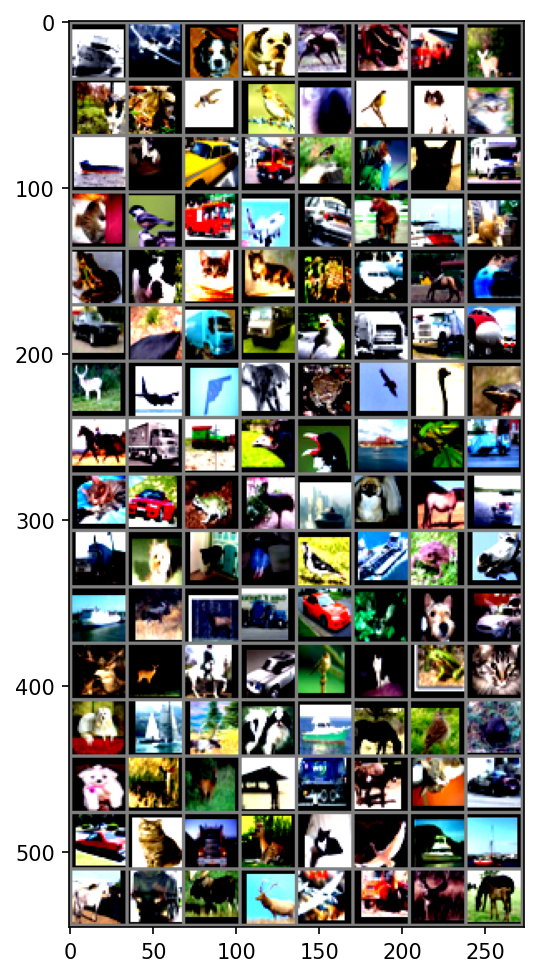

 ship plane   dog   dog  deer


In [69]:
# functions to show an image

from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 8), dpi=150, facecolor='w', edgecolor='k')
# functions to show an image
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(5)))

In [70]:
# Shufflenet Architecture

class ShuffleBlock(nn.Module):
    def __init__(self, groups):
        super(ShuffleBlock, self).__init__()
        self.groups = groups

    def forward(self, x):
        '''Channel shuffle: [N,C,H,W] -> [N,g,C/g,H,W] -> [N,C/g,g,H,w] -> [N,C,H,W]'''
        N,C,H,W = x.size()
        g = self.groups
        return x.view(N,g,C//g,H,W).permute(0,2,1,3,4).reshape(N,C,H,W)


class Bottleneck(nn.Module):
    def __init__(self, in_planes, out_planes, stride, groups):
        super(Bottleneck, self).__init__()
        self.stride = stride

        mid_planes =int(out_planes/4)
        g = 1 if in_planes==24 else groups
        self.conv1 = nn.Conv2d(in_planes, mid_planes, kernel_size=1, groups=g, bias=False)
        self.bn1 = nn.BatchNorm2d(mid_planes)
        self.shuffle1 = ShuffleBlock(groups=g)
        self.conv2 = nn.Conv2d(mid_planes, mid_planes, kernel_size=3, stride=stride, padding=1, groups=mid_planes, bias=False)
        self.bn2 = nn.BatchNorm2d(mid_planes)
        self.conv3 = nn.Conv2d(mid_planes, out_planes, kernel_size=1, groups=groups, bias=False)
        self.bn3 = nn.BatchNorm2d(out_planes)

        self.shortcut = nn.Sequential()
        if stride == 2:
            self.shortcut = nn.Sequential(nn.AvgPool2d(3, stride=2, padding=1))

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.shuffle1(out)
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        res = self.shortcut(x)
        out = F.relu(torch.cat([out,res], 1)) if self.stride==2 else F.relu(out+res)
        return out


class ShuffleNet(nn.Module):
    def __init__(self, cfg):
        super(ShuffleNet, self).__init__()
        out_planes = cfg['out_planes']
        num_blocks = cfg['num_blocks']
        groups = cfg['groups']

        self.conv1 = nn.Conv2d(3, 24, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(24)
        self.in_planes = 24
        self.layer1 = self._make_layer(out_planes[0], num_blocks[0], groups)
        self.layer2 = self._make_layer(out_planes[1], num_blocks[1], groups)
        self.layer3 = self._make_layer(out_planes[2], num_blocks[2], groups)
        self.linear = nn.Linear(out_planes[2], 10)

    def _make_layer(self, out_planes, num_blocks, groups):
        layers = []
        for i in range(num_blocks):
            stride = 2 if i == 0 else 1
            cat_planes = self.in_planes if i == 0 else 0
            layers.append(Bottleneck(self.in_planes, out_planes-cat_planes, stride=stride, groups=groups))
            self.in_planes = out_planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ShuffleNetG2():
    cfg = {
        'out_planes': [200,400,800],
        'num_blocks': [4,8,4],
        'groups': 2
    }
    return ShuffleNet(cfg)

def ShuffleNetG3():
    cfg = {
        'out_planes': [240,480,960],
        'num_blocks': [4,8,4],
        'groups': 3
    }
    return ShuffleNet(cfg)


net = ShuffleNetG2()
x = torch.randn(1,3,32,32)
y = net(x)
print(y)

tensor([[ 1.0043,  0.2848,  0.9666,  0.3624,  0.3342,  0.6269,  0.3959, -0.2291,
         -0.6163,  0.8192]], grad_fn=<AddmmBackward>)


In [71]:
net = ShuffleNetG2()
print(net)

ShuffleNet(
  (conv1): Conv2d(3, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(24, 44, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(44, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shuffle1): ShuffleBlock()
      (conv2): Conv2d(44, 44, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=44, bias=False)
      (bn2): BatchNorm2d(44, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(44, 176, kernel_size=(1, 1), stride=(1, 1), groups=2, bias=False)
      (bn3): BatchNorm2d(176, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential(
        (0): AvgPool2d(kernel_size=3, stride=2, padding=1)
      )
    )
    (1): Bottleneck(
      (conv1): Conv2d(200, 50, kernel_size=(1, 1), stride=(1, 1), groups=2, 

In [0]:
# Setting the model on cuda
if torch.cuda.is_available():
    net.cuda()

# Hyper parameters
criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
optimizer = optim.Adam(net.parameters(), lr=0.01)

In [0]:
# Training
def train_net():
    net.train()
    train_loss = 0
    n_correct = 0
    n_total = 0
    for batch_size, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        n_correct += predicted.eq(targets).sum().item()
        n_total += targets.shape[0]
    return train_loss/(batch_size+1),n_correct/n_total

def get_loss_acc(is_test_dataset = True):
    net.eval()
    dataloader = test_loader if is_test_dataset else train_loader
    n_correct = 0
    n_total = 0
    test_loss = 0
    with torch.no_grad():
        for batch_size, (inputs, targets) in enumerate(dataloader):
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = net(inputs)
            test_loss += criterion(outputs, targets).item()
            _, predicted = outputs.max(1)
            n_correct += predicted.eq(targets).sum().item()
            n_total += targets.shape[0]
    return test_loss/(batch_size+1),n_correct/n_total

In [0]:
def test(epoch):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            print(batch_idx, len(test_loader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))
  # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': net.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/ckpt.pth')
        best_acc = acc


In [0]:
def lr_schedule(epoch):
    batch_size = 256
#    if epoch > 10:
#        batch_size = 128
#    if epoch > 20:
#        batch_size = 64
    return batch_size

In [100]:
EPOCH = 20
start = dt.datetime.now()
start_epoch=0
for epochi in range(start_epoch,start_epoch + EPOCH):

    batch_size = lr_schedule(epochi)
    #scheduler.step()
    cur_lr = [i['lr'] for i in optimizer.param_groups][0]
    print("Btach Size",batch_size,'(%.2fs)\n\nEpoch: %d/%d | cur_lr:%.4f ' % (
       (dt.datetime.now()-start).seconds, epochi+1,EPOCH+start_epoch,cur_lr))
    start = dt.datetime.now()
    

    test_loss , test_acc = get_loss_acc()
    train_loss , train_acc = train_net()
    #hist.append([train_loss , train_acc,test_loss , test_acc])
    print( 'train Loss: %.3f | Acc: %.3f%% \ntest Loss: %.3f | Acc: %.3f%% ' % (
        train_loss, train_acc*100,test_loss, test_acc*100))

Btach Size 256 (0.00s)

Epoch: 1/20 | cur_lr:0.0100 
train Loss: 0.112 | Acc: 96.122% 
test Loss: 0.431 | Acc: 88.640% 
Btach Size 256 (31.00s)

Epoch: 2/20 | cur_lr:0.0100 
train Loss: 0.109 | Acc: 96.176% 
test Loss: 0.459 | Acc: 87.820% 
Btach Size 256 (30.00s)

Epoch: 3/20 | cur_lr:0.0100 
train Loss: 0.107 | Acc: 96.182% 
test Loss: 0.456 | Acc: 88.360% 
Btach Size 256 (30.00s)

Epoch: 4/20 | cur_lr:0.0100 
train Loss: 0.106 | Acc: 96.190% 
test Loss: 0.451 | Acc: 87.950% 
Btach Size 256 (30.00s)

Epoch: 5/20 | cur_lr:0.0100 
train Loss: 0.106 | Acc: 96.196% 
test Loss: 0.508 | Acc: 87.530% 
Btach Size 256 (30.00s)

Epoch: 6/20 | cur_lr:0.0100 
train Loss: 0.100 | Acc: 96.420% 
test Loss: 0.437 | Acc: 88.350% 
Btach Size 256 (30.00s)

Epoch: 7/20 | cur_lr:0.0100 
train Loss: 0.100 | Acc: 96.440% 
test Loss: 0.486 | Acc: 87.880% 
Btach Size 256 (30.00s)

Epoch: 8/20 | cur_lr:0.0100 
train Loss: 0.103 | Acc: 96.350% 
test Loss: 0.478 | Acc: 88.070% 
Btach Size 256 (30.00s)

Epoch: 9

In [0]:
def count_parameters(model):
    pytorch_total_params = sum(p.numel() for p in model.parameters())
    print("Total_params",pytorch_total_params)
    pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print("Trainable_params",pytorch_total_params)

In [102]:
count_parameters(net)

Total_params 887582
Trainable_params 887582


In [103]:
total_correct = 0
total_images = 0
confusion_matrix = np.zeros([10,10], int)
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total_images += labels.size(0)
        total_correct += (predicted == labels).sum().item()
        for i, l in enumerate(labels):
            confusion_matrix[l.item(), predicted[i].item()] += 1 

model_accuracy = total_correct / total_images * 100
print('Model accuracy on {0} test images: {1:.2f}%'.format(total_images, model_accuracy))

Model accuracy on 10000 test images: 88.38%


In [104]:
print('{0:10s} - {1}'.format('Category','Accuracy'))
for i, r in enumerate(confusion_matrix):
    print('{0:10s} - {1:.1f}'.format(classes[i], r[i]/np.sum(r)*100))

Category   - Accuracy
plane      - 89.9
car        - 96.2
bird       - 84.6
cat        - 76.0
deer       - 92.3
dog        - 80.7
frog       - 94.4
horse      - 90.4
ship       - 91.1
truck      - 88.2


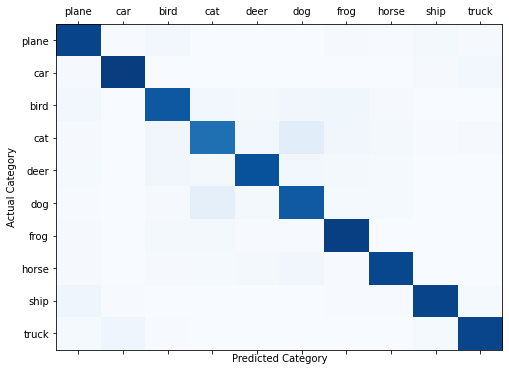

In [97]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.matshow(confusion_matrix, aspect='auto', vmin=0, vmax=1000, cmap=plt.get_cmap('Blues'))
plt.ylabel('Actual Category')
plt.yticks(range(10), classes)
plt.xlabel('Predicted Category')
plt.xticks(range(10), classes)
plt.show()

In [0]:
torch.save(net.state_dict(), 'shufflenet.ckpt')